# Разработка модели классификации на фродовые заказы


Ключевые этапы:
* Изучить предоставленные данные и провести первичный анализ (EDA).
* Разработать и обучить модель классификации (учитывая сильный дисбаланс классов 1:10).
* Оценить качество модели с фокусом на метрики для миноритарного класса.
* Реализовать прототип сервиса (django/FastAPI/Flask/Streamlit/Gradio или др.):
  * Принимает табличные данные,
  * Возвращает предсказанную метку и вероятность.
* Подготовить отчёт, описав подход, ключевые результаты и инструкцию по запуску.


## Структура данных

Датасет представлен в табличном формате и содержит следующие колонки:

`user_id` - идентификатор пользователя

`created_date` - дата создания записи

`nm_id` - идентификатор товара

`total_ordered` - общее количество заказанных товаров

`payment_type` - тип оплаты

`is_paid` - флаг оплаты (булево значение)

`count_items` - количество товаров за последнее время

`unique_items` - количество уникальных товаров за последнее время

`avg_unique_purchase` - среднее количество уникальных покупок за последнее время

`is_courier` - флаг доставки курьером

`nm_age` - возраст товара

`Distance` - расстояние

`days_after_registration` - дни после регистрации

`number_of_orders` - количество заказов

`number_of_ordered_items` - количество заказанных товаров

`mean_number_of_ordered_items` - среднее количество заказанных товаров

`min_number_of_ordered_items` - минимальное количество заказанных товаров

`max_number_of_ordered_items` - максимальное количество заказанных товаров

`mean_percent_of_ordered_items` - средний процент заказанных товаров

`target` - целевая переменная (0 - не требуется блокировка, 1 - требуется блокировка)

`service` - тип региона

Датасет имеет сильный дисбаланс классов в соотношении 1:10 (класс 1 встречается значительно реже).


## Требования к задаче

**Анализ данных (EDA):**
* Исследовать распределение признаков
* Проанализировать дисбаланс (сколько объектов каждого класса)
* Выявить корреляции между признаками
* Проверить наличие пропущенных значений и выбросов

**Предобработка данных:**
* Обработка пропущенных значений
* Кодирование категориальных признаков
* Масштабирование числовых признаков
* Работа с дисбалансом классов (SMOTE, undersampling, class weights и т.д.)

**Построение модели:**
* Любой фреймворк (scikit-learn, XGBoost, LightGBM, CatBoost и т.д.)
* Можно использовать ансамблевые методы
* Учитывать баланс между качеством и скоростью

**Оценка качества:**
* Основные метрики для миноритарного класса: Precision и Recall
* Дополнительные метрики: F1-score, PR-AUC, ROC-AUC
* Обязательная оценка Confusion Matrix

**Подготовка результатов:**
* Валидация: подбираем гиперпараметры
* Тест: итоговая метрика

**Развёртывание сервиса:**
* REST API (Flask/FastAPI) либо UI (Streamlit/Gradio)
* /predict эндпоинт, возвращающий {"prediction": 0 или 1, "confidence": float}

**Отчёт:**
* Описание подхода, модели, метрик
* Результаты на тесте


## Методика оценки

**Оценка качества модели для миноритарного (целевого) класса:**
* Неудовлетворительный результат:
  * Recall < 0.1 при Precision < 0.75
* Хороший результат:
  * 0.1 ≤ Recall при 0.8 ≤ Precision 
* Победитель:
  * Recall ≥ 0.1 при максимальном Precision

**Дополнительные метрики:**
* F1-score — комбинированная метрика Precision и Recall (используется для сравнения моделей)
* PR-AUC — особенно важна для несбалансированных данных
* ROC-AUC — оценка разделительной способности модели


### Рассмотрим распределение признаков

In [48]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data_train = pd.read_csv('./data/df_train.csv')

display(data_train.head())

,user_id,nm_id,CreatedDate,service,total_ordered,PaymentType,IsPaid,count_items,unique_items,avg_unique_purchase,...,NmAge,Distance,DaysAfterRegistration,number_of_orders,number_of_ordered_items,mean_number_of_ordered_items,min_number_of_ordered_items,max_number_of_ordered_items,mean_percent_of_ordered_items,target
0,1,1,2025-01-05 02:20:24+03:00,nnsz,627,CSH,False,4,4,1.00,...,117,3443,73,1,627,627.0,627,627,100.000000,0
1,2,2,2024-11-05 09:05:21+03:00,nnsz,512,CRD,True,0,0,0.00,...,920,3478,1237,2,606,303.0,94,512,50.000000,0
2,3,3,2024-12-11 13:45:33+03:00,nnsz,500,CRD,True,0,0,0.00,...,420,771,4003,1,500,500.0,500,500,100.000000,0
3,4,4,2025-01-24 07:47:34+03:00,nnsz,452,CSH,False,6,2,0.33,...,20112,763,977,5,1102,220.4,100,452,20.000000,0
4,5,5,2024-11-27 11:50:43+03:00,nnsz,450,CRD,True,0,0,0.00,...,141,1089,1637,3,549,183.0,1,450,33.333333,0


In [49]:
display(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105565 entries, 0 to 105564
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   user_id                        105565 non-null  int64  
 1   nm_id                          105565 non-null  int64  
 2   CreatedDate                    105565 non-null  object 
 3   service                        105565 non-null  object 
 4   total_ordered                  105565 non-null  int64  
 5   PaymentType                    105565 non-null  object 
 6   IsPaid                         105565 non-null  bool   
 7   count_items                    105565 non-null  int64  
 8   unique_items                   105565 non-null  int64  
 9   avg_unique_purchase            105565 non-null  float64
 10  is_courier                     105565 non-null  int64  
 11  NmAge                          105565 non-null  int64  
 12  Distance                      

None

Пропусков нет, все типы данных соответствуют записям в этих колонках, можно перевести данные о времени в datetime и переименовать часть колонок в snake case

In [50]:
# Обернем в функцию чтобы после применить на тестовом датасете
def base_preprocess(df):

    columns = list(df.columns)

    # Последовательное переименование каждого столбца в snake case
    for i, column in enumerate(columns):
        columns[i] = ''.join(['_' + i.lower() if i.isupper() else i for i in column]).lstrip('_')

    df.columns = columns

    # Преобразование столбца со временем в datetime
    df['created_date'] = pd.to_datetime(df['created_date'])

    df['day'] = df['created_date'].dt.day
    df['hour'] = df['created_date'].dt.hour
    df['weekday'] = df['created_date'].dt.weekday

    return df

In [51]:
# Вызываем функцию для тренировочного датасета
data_train = base_preprocess(data_train)

In [52]:
display(data_train['target'].value_counts())

target
0    92211
1    13354
Name: count, dtype: int64

Наблюдается дисбаланс классов в target, что нужно будет учесть при обучени моделей

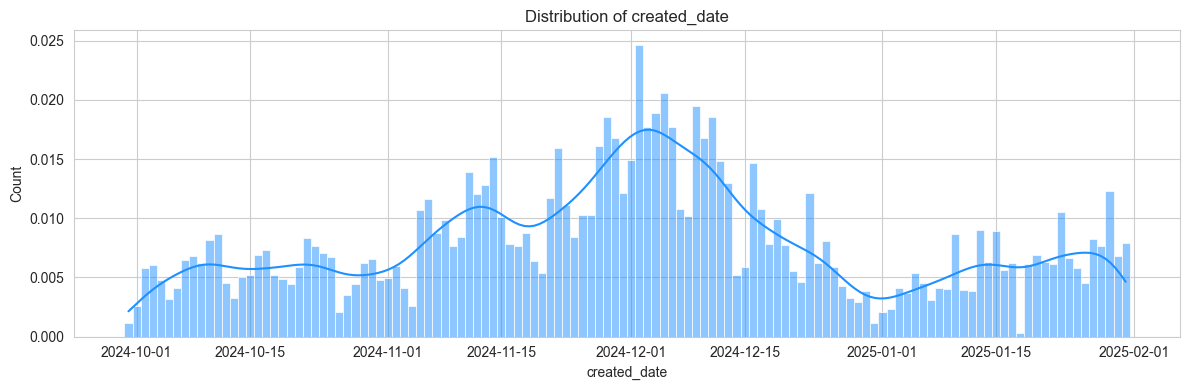

C:\Users\reserford\AppData\Local\Temp\ipykernel_23140\583982557.py:19: UserWarning: 
The palette list has fewer values (3) than needed (31) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=data_train[col], palette=['beige','dodgerblue', 'red'],


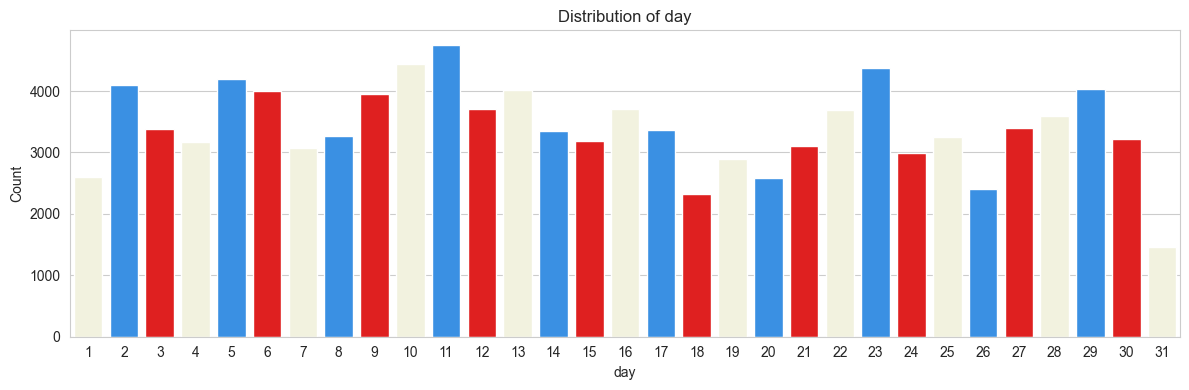

C:\Users\reserford\AppData\Local\Temp\ipykernel_23140\583982557.py:19: UserWarning: 
The palette list has fewer values (3) than needed (24) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=data_train[col], palette=['beige','dodgerblue', 'red'],


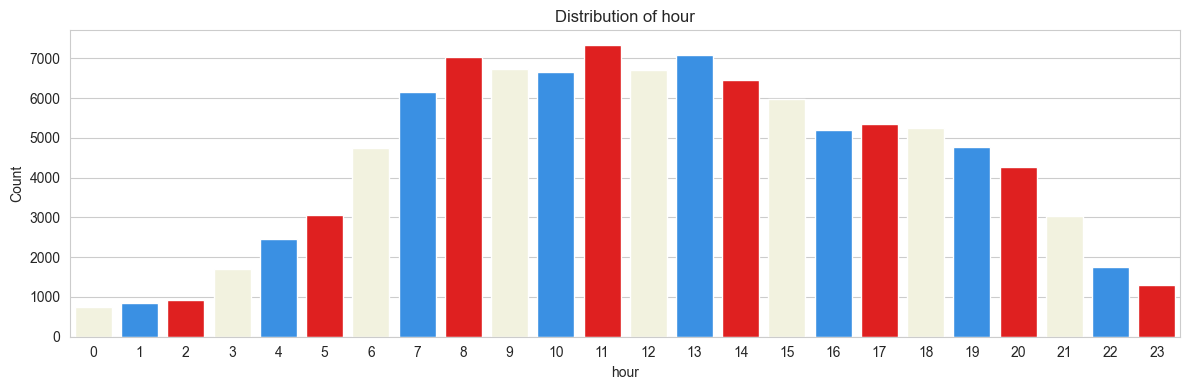

C:\Users\reserford\AppData\Local\Temp\ipykernel_23140\583982557.py:19: UserWarning: 
The palette list has fewer values (3) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=data_train[col], palette=['beige','dodgerblue', 'red'],


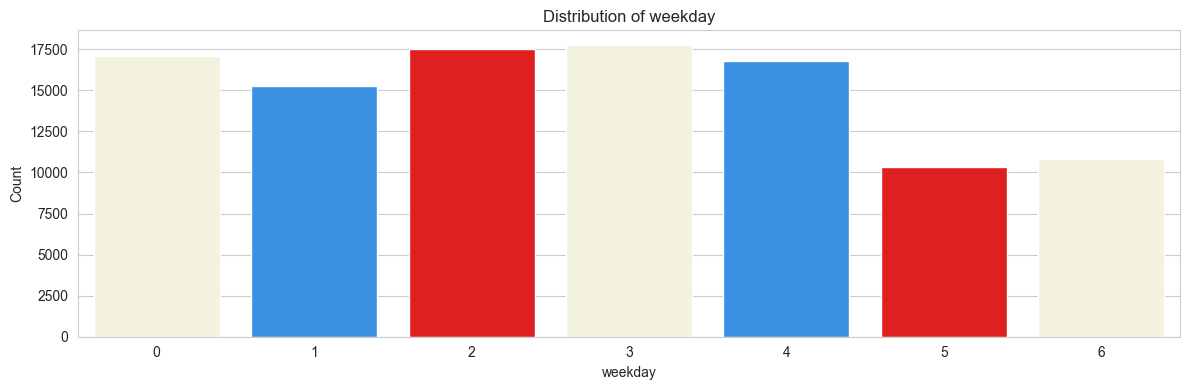

In [53]:
# Строим графики распределения для дат
plt.figure(figsize=(12, 4))
sns.histplot(data_train['created_date'].dt.date,
            color='dodgerblue',
            bins = 100,
            kde=True,     
            edgecolor='white',  
            linewidth=0.5,      
            stat='density') 
plt.title('Distribution of created_date')
plt.xlabel('created_date')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Строим графики распределения для времени
for col in ["day", "hour", "weekday"]:
    plt.figure(figsize=(12, 4))
    sns.countplot(x=data_train[col], palette=['beige','dodgerblue', 'red'], 
                  legend=False, hue=data_train[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

Так как у нас есть даныные только за несколько месяцев, нельзя отследить по другим годам, соответствует ли распределение по датам ожидаемому, тем не менее распределения правдоподобны

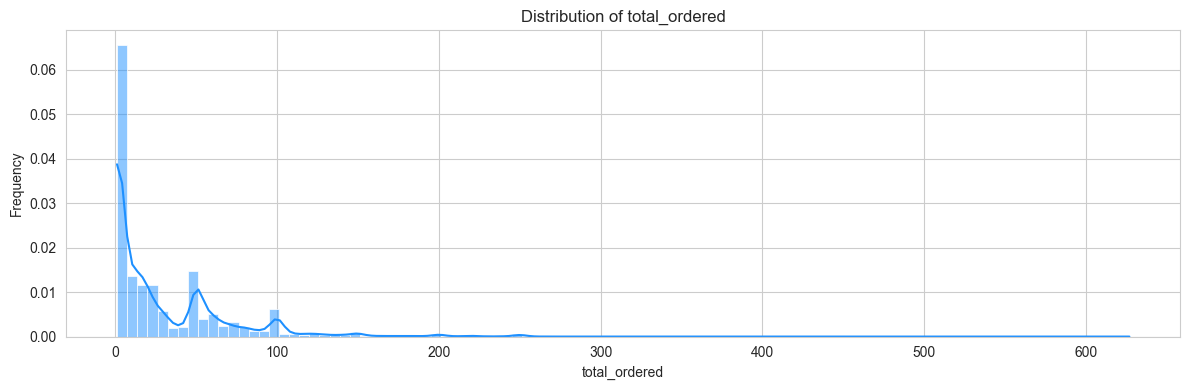

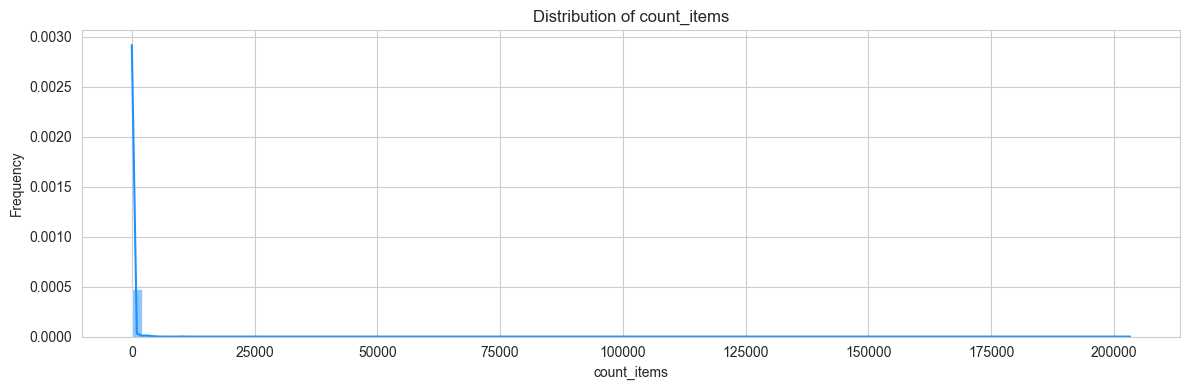

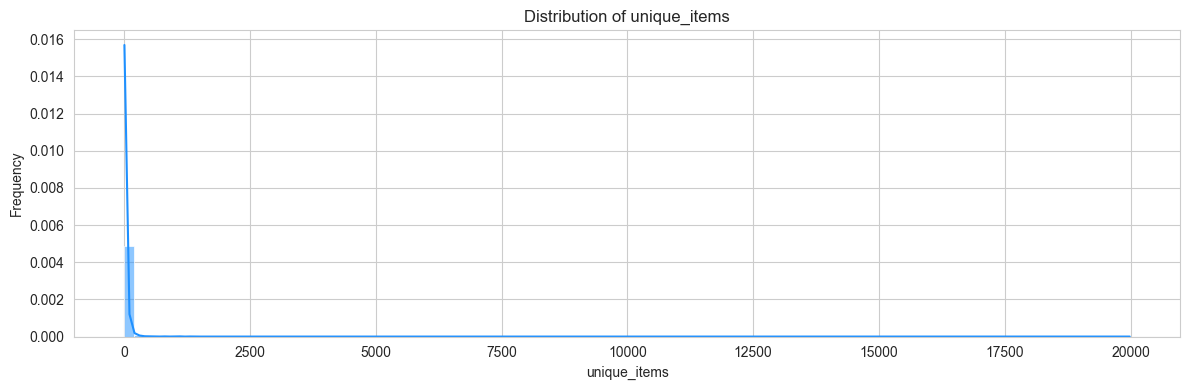

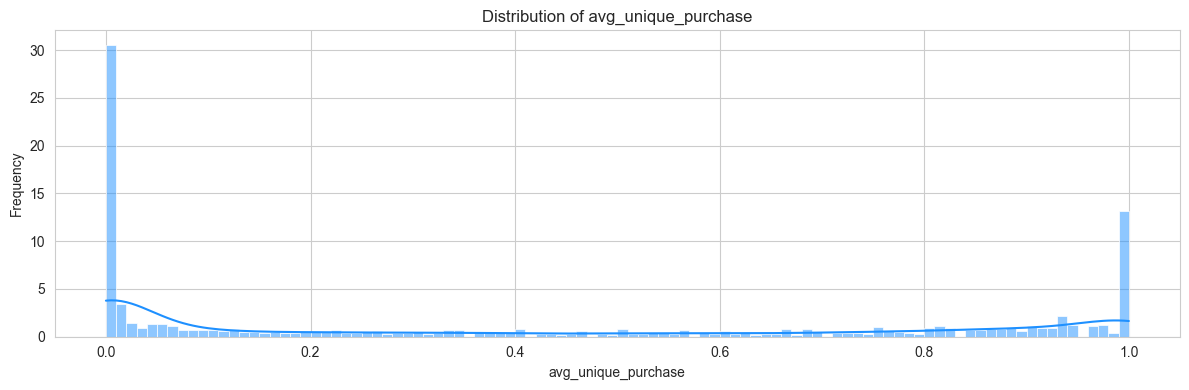

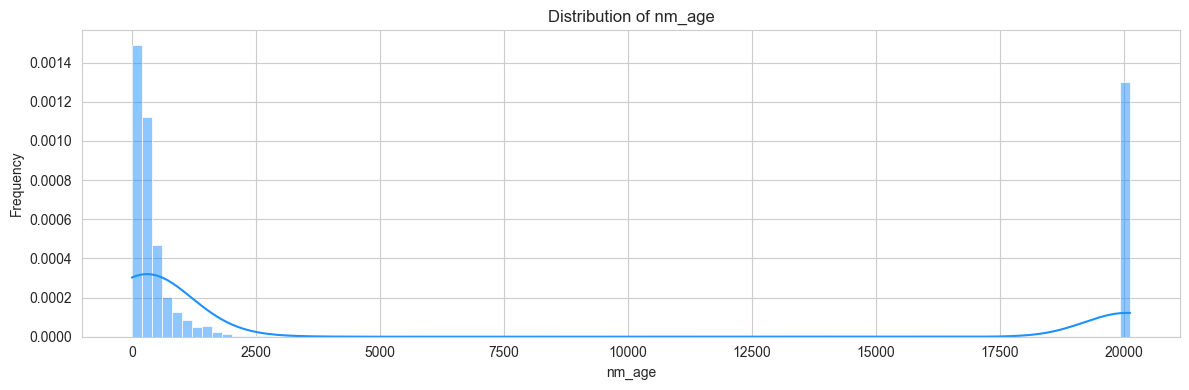

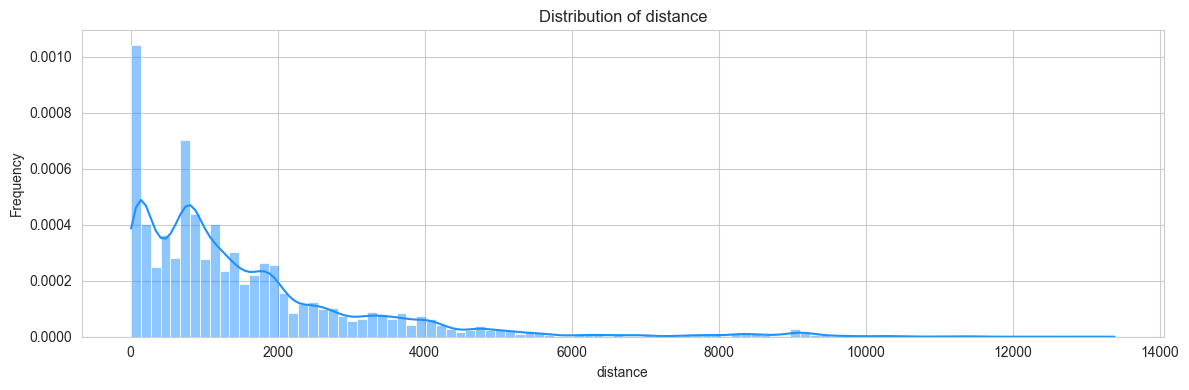

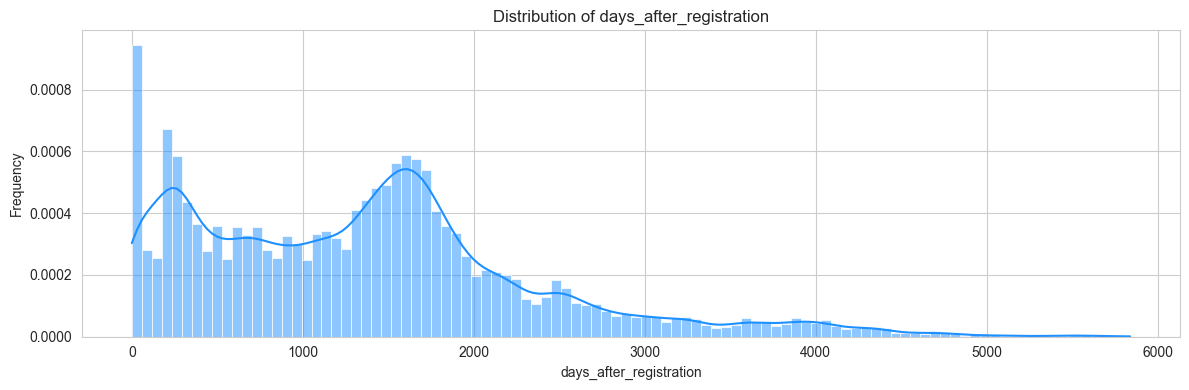

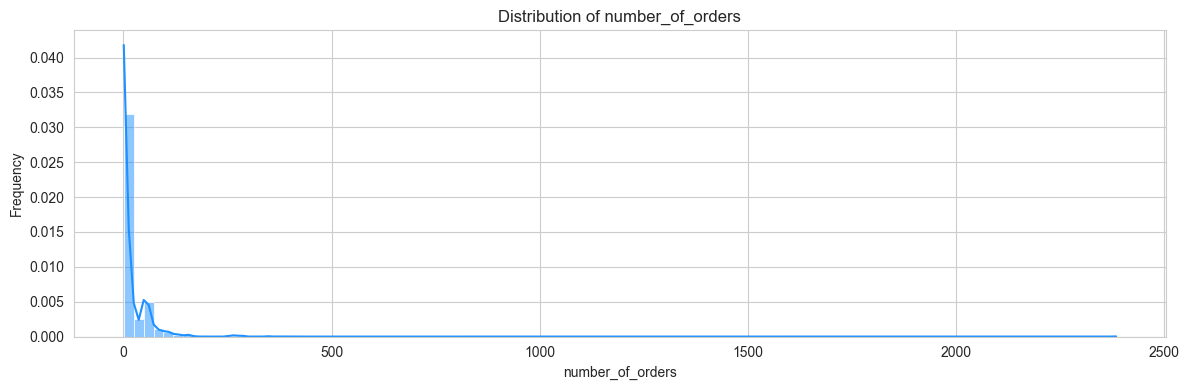

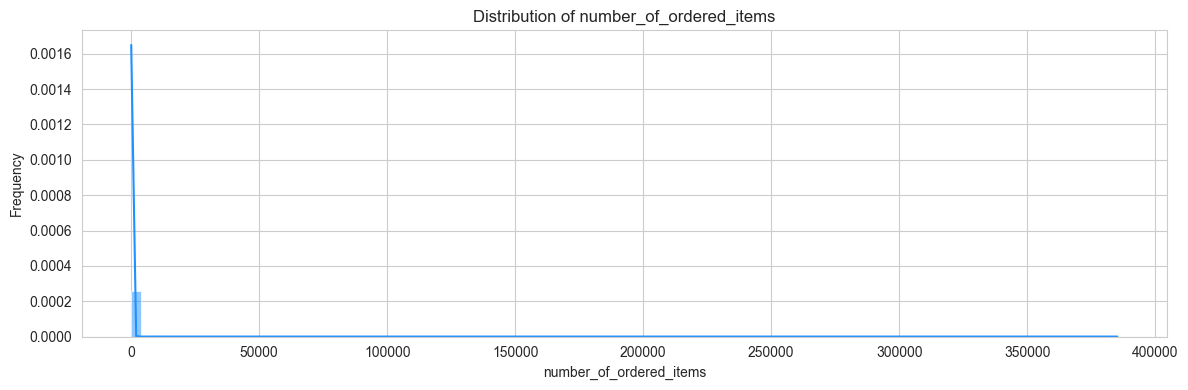

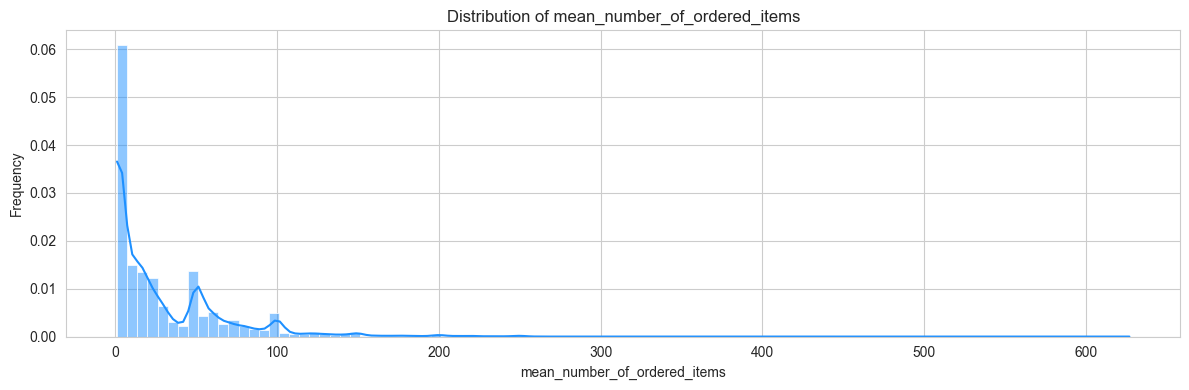

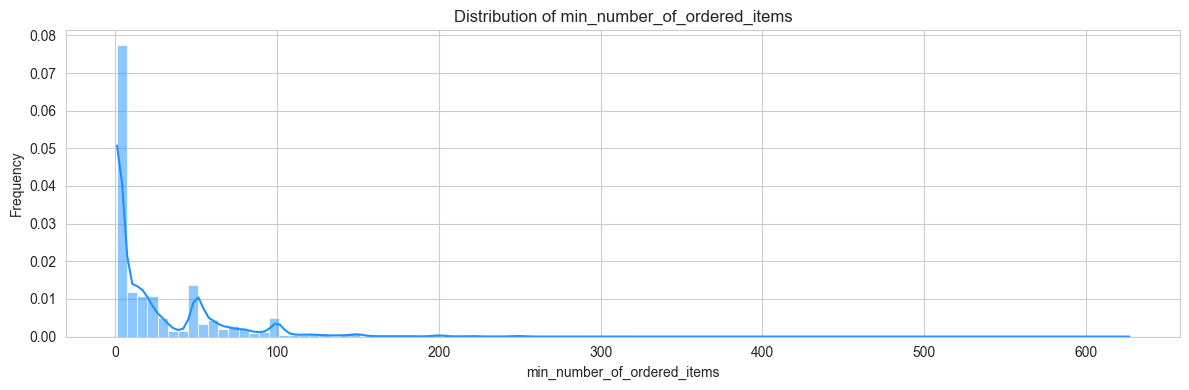

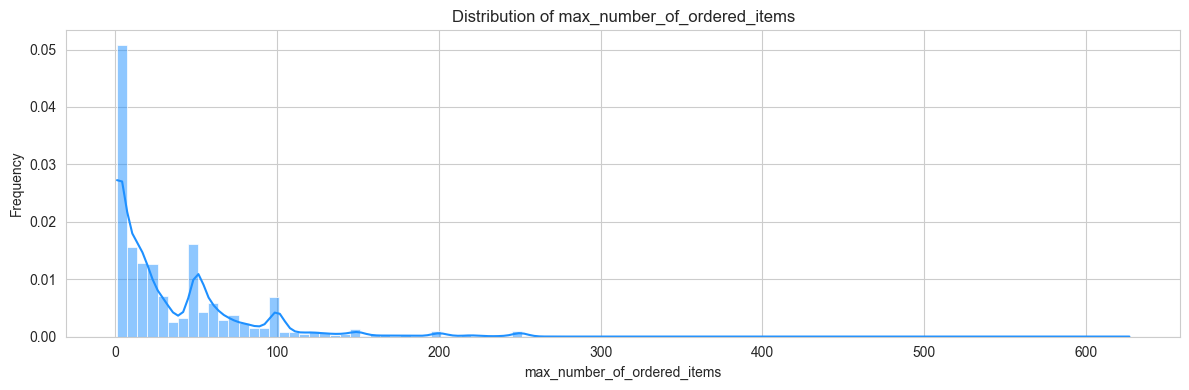

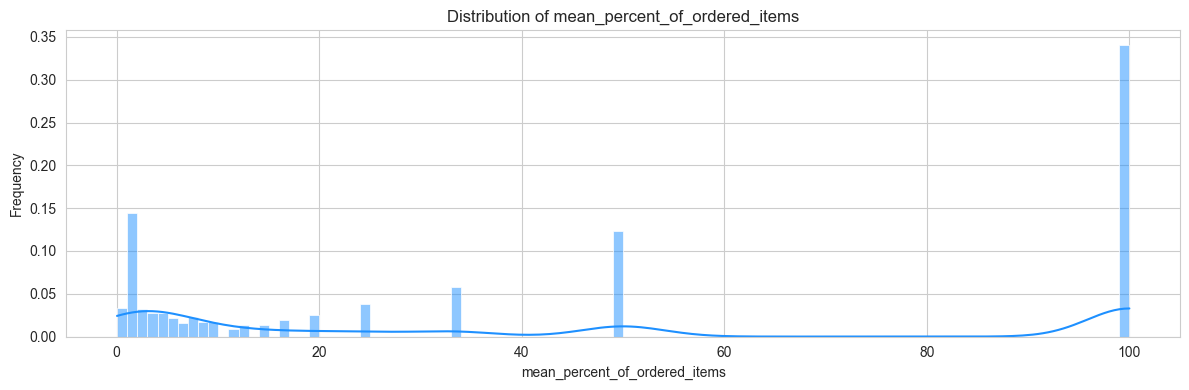

In [54]:
sns.set_style('whitegrid')

# Фильтруем категориальные и численные параметры и исключаем айди
cat_columns = ["is_paid", "is_courier", "service", "payment_type"]

numerical_columns = [
    col for col in data_train.select_dtypes(include=['float64', 'int64']).columns
    if ('id' not in col.lower()) and (col not in cat_columns) and (col != 'target')
]

# Строим для каждого гистограммы распределения
for i, col in enumerate(numerical_columns, 1):
    plt.figure(figsize=(12, 4))
    sns.histplot(
        data_train[col],
        color='dodgerblue',
        bins = 100,
        kde=True,     
        edgecolor='white',  
        linewidth=0.5,      
        stat='density' if data_train[col].nunique() > 20 else 'count'  
    )
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Распределения соответствуют ожидаемым, при этом наблюдаем пики в `total_ordered`, `number_of_ordered_items`, `mean_percent_of_ordered_items` на 50, 100 и кратных им, а также пик в `days_after_registration` на нуле, эти пики могут свидетельствовать о фроде

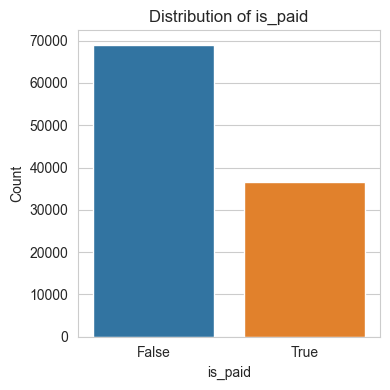

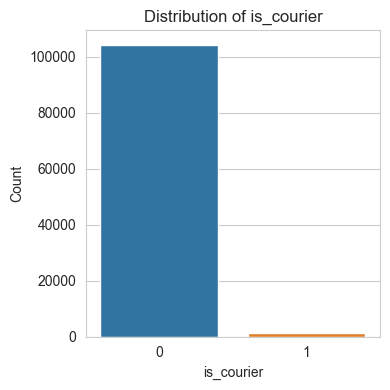

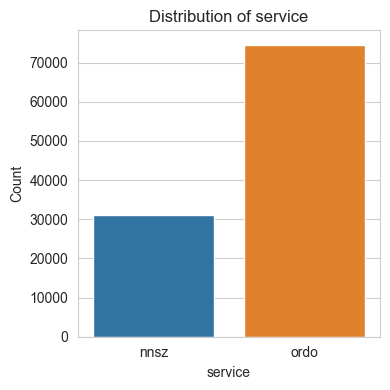

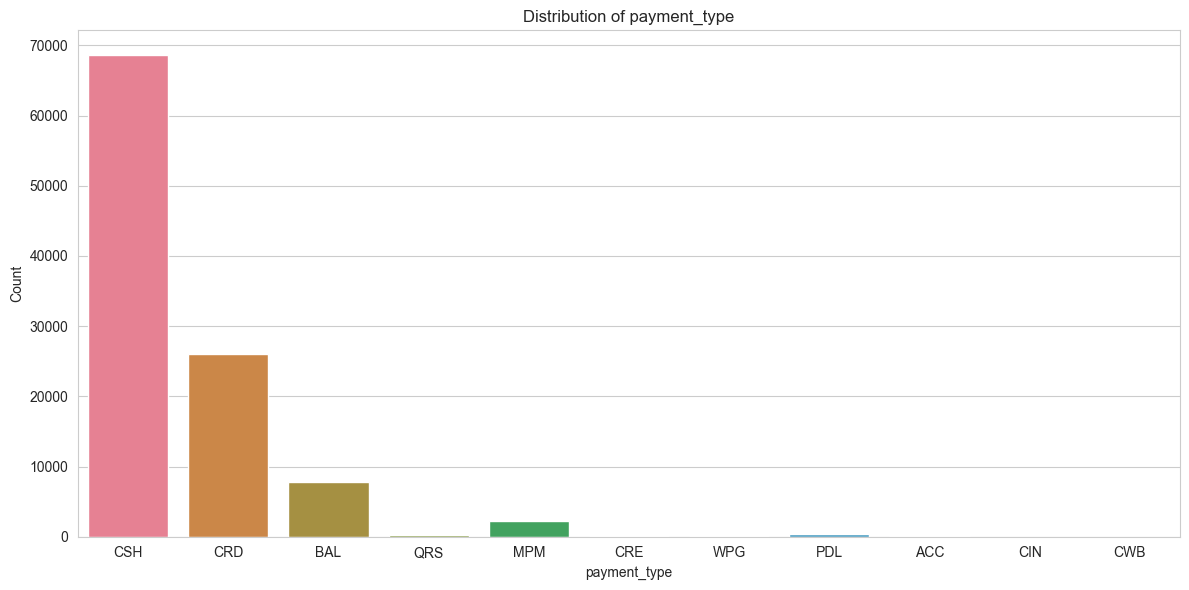

In [55]:
# Строим графики распределения категориальных переменных
for i, col in enumerate(cat_columns):
    plt.figure(figsize=(4, 4)) if len(data_train[col].unique()) <= 2 else plt.figure(figsize=(12, 6))
    sns.countplot(x=data_train[col], legend=False, hue=data_train[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [56]:
# Импортируем библиотеки и методы для машинного обучения
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, classification_report, roc_auc_score, f1_score

from catboost import Pool, CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

RANDOM_STATE=42

In [57]:
# Скачиваем тестовый датасет
data_test = pd.read_csv('./data/df_test.csv')
data_test = base_preprocess(data_test)
data_test.head()

,user_id,nm_id,created_date,service,total_ordered,payment_type,is_paid,count_items,unique_items,avg_unique_purchase,...,number_of_orders,number_of_ordered_items,mean_number_of_ordered_items,min_number_of_ordered_items,max_number_of_ordered_items,mean_percent_of_ordered_items,target,day,hour,weekday
0,35434,37225,2025-03-02 16:13:47+03:00,nnsz,854,CSH,False,0,0,0.00,...,1,854,854.0,854,854,100.0,1,2,16,6
1,35435,37226,2025-02-08 06:40:18+03:00,ordo,534,QRS,False,125,33,0.26,...,5,1062,212.4,88,534,20.0,0,8,6,5
2,35436,37227,2025-03-18 14:59:40+03:00,ordo,472,CRD,True,0,0,0.00,...,1,472,472.0,472,472,100.0,1,18,14,1
3,35437,338,2025-02-16 14:02:28+03:00,ordo,440,CSH,False,2212,9,0.00,...,1,440,440.0,440,440,100.0,0,16,14,6
4,35438,37228,2025-03-17 08:24:32+03:00,nnsz,400,CSH,False,0,0,0.00,...,1,400,400.0,400,400,100.0,0,17,8,0


In [58]:
# Отбираем меньше наблюдений, чтобы быстрее считалось
data_percent, _ = train_test_split(
    data_train,
    train_size=0.8,
    stratify=data_train['target'], 
    random_state=RANDOM_STATE
)

print(data_train['target'].value_counts() / data_train.shape[0])
print(data_percent['target'].value_counts() / data_percent.shape[0])
# уменьшили выборку, сохранив соотношение классов в target

target
0    0.8735
1    0.1265
Name: count, dtype: float64
target
0    0.873502
1    0.126498
Name: count, dtype: float64


## Scaling (а он нам нужен вообще?)

In [59]:
# # Отнормируем признаки для лог. регрессии
# from sklearn.preprocessing import MinMaxScaler

# cols_to_scale = list(data_percent.select_dtypes(include=['int64', 'float64']).columns) 
# cols_to_scale  = [x for x in cols_to_scale if x not in['is_courier','user_id', 'nm_id', 'target', 'day', 'hour','weekday']]  
# print(cols_to_scale)
# # Копируем DataFrame, чтобы не изменять исходный
# data_scaled = data_percent.copy()
# print(data_scaled.shape)
# # Применяем MinMaxScaler только к выбранным столбцам
# scaler = MinMaxScaler()
# data_scaled[cols_to_scale] = scaler.fit_transform(data_percent[cols_to_scale])
# data_scaled

## Encoding

In [60]:
from sklearn.preprocessing import OneHotEncoder

# Создадим декоратор для preprocess
def encode_categoricals(df, cat_columns):
    # Инициализация и обучение OHE
    encoder = OneHotEncoder(sparse_output=False, drop='first') 
    encoded_data = encoder.fit_transform(df[cat_columns])

    # Преобразуем в DataFrame
    encoded_df = pd.DataFrame(
        encoded_data,
        columns=encoder.get_feature_names_out(cat_columns)
    )

    # Объединяем с исходными данными
    df = pd.concat([df.drop(cat_columns, axis=1), encoded_df], axis=1)

    return df

In [61]:
data_encoded = encode_categoricals(data_train, cat_columns)

In [65]:
X = data_encoded.drop(['target', 'created_date', 'user_id', 'nm_id'] , axis=1)
y = data_encoded.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=True, stratify=y, random_state = RANDOM_STATE)

# Oversampling

In [ ]:
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=RANDOM_STATE)
X_res, y_res = ada.fit_resample(X, y)

# Log Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, solver='liblinear')

# Параметры для перебора
params = {
    'C': [0.001, 0.01, 0.1, 0.5, 1.0]
}

# Настраиваем GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,  # Используем все ядра процессора
    verbose=1,
    refit=True  # Переобучит модель на лучших параметрах
)

# Запускаем поиск
grid_search.fit(X_train, y_train)

# Результаты
print(f"Лучший параметр C: {grid_search.best_params_['C']}")
print(f"Лучшее ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")

# Качество на тестовой выборке (если нужно)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC на тестовой выборке: {test_roc_auc:.4f}")
# ваш код здесь

# Catboost

In [ ]:
params = {
    'max_depth': list(range(7, 15)),
    'n_estimators': [50, 100, 150],
    'random_state' : [RANDOM_STATE]
}

# Подготовка данных
cat_features = ['service', 'PaymentType', 'IsPaid'] # индексы категориальных признаков

cbc = CatBoostClassifier(random_state=RANDOM_STATE, 
                         cat_features=cat_features,
                         verbose=0)
grid_search_cv_clf_cat = GridSearchCV(cbc, params, cv=5,
                                    scoring='f1',
                                    n_jobs=-1,  # Используем все ядра процессора
                                    verbose=0,
                                    refit=True  # Переобучит модель на лучших параметрах
)
grid_search_cv_clf_cat.fit(X_train, y_train, verbose=False)

# Make predictions on the test set
y_pred = grid_search_cv_clf_cat.predict(X_test)

# Результаты
print(f"Лучший параметр глубина дерева: {grid_search_cv_clf_cat.best_params_}")
print(f"Лучшее F1 на кросс-валидации: {grid_search_cv_clf_cat.best_score_:.4f}")
results_df = pd.DataFrame(grid_search_cv_clf_cat.cv_results_)

# Выводим средние значения F1-score для каждой комбинации параметров
print(results_df[['params', 'mean_test_score', 'std_test_score']])

# Качество на тестовой выборке (если нужно)
y_pred_proba = grid_search_cv_clf_cat.predict_proba(X_test)[:, 1]
f1_score_ = f1_score(y_test, y_pred, average='weighted')
print(f"F1 на тестовой выборке: {f1_score_:.4f}")

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
#Решил убрать время вообще пока что
X_ = data_test.drop(['target', 'CreatedDate_datetime', 'CreatedDate'] , axis=1)
y_ = data_test.target
y_pred_test = grid_search_cv_clf_cat.predict(X_)

In [ ]:
print(classification_report(y_, y_pred_test))